In this notebook, I model 1-day 99% VaR for a Portfolio consisting of Stocks by using two methods: Historical Simulation and Monte Carlo Simulation. 

In [28]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats

Consider Portfolio consisting of positions in 5 Stocks with equal weights. Total value of the Portfolio is 1 Million USD. Let us use the stock data for three years from 2022 to 2024. 

In [29]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'META', 'TSLA']

df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start='2022-01-01', end='2024-01-01',auto_adjust=True)
    df[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [30]:
df

,AAPL,MSFT,GOOG,META,TSLA
Date,,,,,
2022-01-03,178.645645,325.038086,144.217224,336.692871,399.926666
2022-01-04,176.378357,319.464569,143.563141,334.693909,383.196655
2022-01-05,171.686691,307.201019,136.840103,322.401306,362.706665
2022-01-06,168.820663,304.773560,136.738205,330.646057,354.899994
2022-01-07,168.987534,304.928986,136.194931,329.979675,342.320007
...,...,...,...,...,...
2023-12-22,192.192566,370.375732,141.876663,351.461884,252.539993
2023-12-26,191.646576,370.454895,141.976074,352.893982,256.609985
2023-12-27,191.745819,369.871490,140.604233,355.877594,261.440002


Calculate the daily returns from each of the Stocks.

In [31]:
returns = df.pct_change()
returns = returns.dropna()
returns

,AAPL,MSFT,GOOG,META,TSLA
Date,,,,,
2022-01-04,-0.012692,-0.017147,-0.004535,-0.005937,-0.041833
2022-01-05,-0.026600,-0.038388,-0.046830,-0.036728,-0.053471
2022-01-06,-0.016693,-0.007902,-0.000745,0.025573,-0.021523
2022-01-07,0.000988,0.000510,-0.003973,-0.002015,-0.035447
2022-01-10,0.000116,0.000732,0.011456,-0.011212,0.030342
...,...,...,...,...,...
2023-12-22,-0.005547,0.002784,0.006488,-0.001977,-0.007701
2023-12-26,-0.002841,0.000214,0.000701,0.004075,0.016116
2023-12-27,0.000518,-0.001575,-0.009662,0.008455,0.018822


In [32]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


Find the daily returns for the whole Portfolio

In [33]:
historical_returns = (returns * weights).sum(axis =1)
print(historical_returns)

Date
2022-01-04   -0.016429
2022-01-05   -0.040403
2022-01-06   -0.004258
2022-01-07   -0.007987
2022-01-10    0.006287
                ...   
2023-12-22   -0.001191
2023-12-26    0.003653
2023-12-27    0.003312
2023-12-28   -0.005179
2023-12-29   -0.007322
Length: 500, dtype: float64


Find the VaR from the Historical Simulation by finding the value at 99 percentile from the distribution of portfolio returns. 1-day 99% VaR for the Portfolio of 1 Million USD is 51610.84 USD.

In [34]:
confidence_interval = 0.99

VaR = -np.percentile(historical_returns, 100 - (confidence_interval * 100))*portfolio_value
print(VaR)

51610.845987009285


Plot the distribution of Porfolio returns along with the VaR 

C:\Users\dande\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


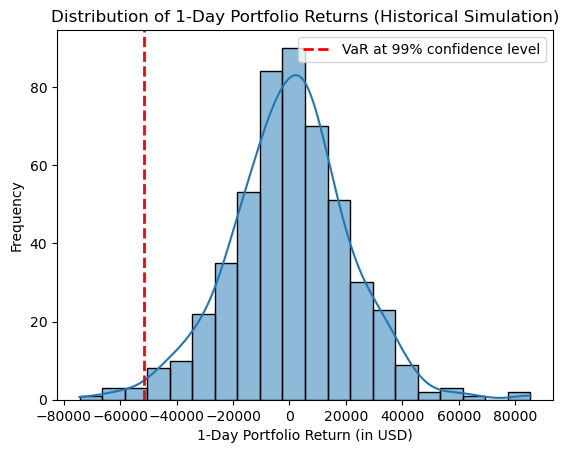

In [35]:
sns.histplot(historical_returns * portfolio_value, bins=20, kde=True)
plt.xlabel('1-Day Portfolio Return (in USD)')
plt.ylabel('Frequency')
plt.title('Distribution of 1-Day Portfolio Returns (Historical Simulation)')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()

Now perform the Monte Carlo Simulation. Start with finding the mean returns and covariance matrix for the Stocks in the Portfolio.

In [36]:
mean_returns = returns.mean().values
cov_matrix = returns.cov().values

Perform 10000 simulations. Use random samples from multivariate normal distribution for the stocks in the Portfolio.

In [37]:
n_simulations = 10000
np.random.seed(42)
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, size=n_simulations)

Find the Portfolio returns. Find VaR using the value at 99 percentile of the distribution of Portfolio returns. 1-day 99% VaR for the Portfolio of 1 Million USD is 48,213.21 USD.

In [38]:
portfolio_returns = simulated_returns @ weights
percentile = np.percentile(portfolio_returns, 1)
VaR_99 = portfolio_value * -percentile
print(VaR_99)

48213.20809107396


Plot the distribution of Porfolio returns along with the VaR 

C:\Users\dande\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


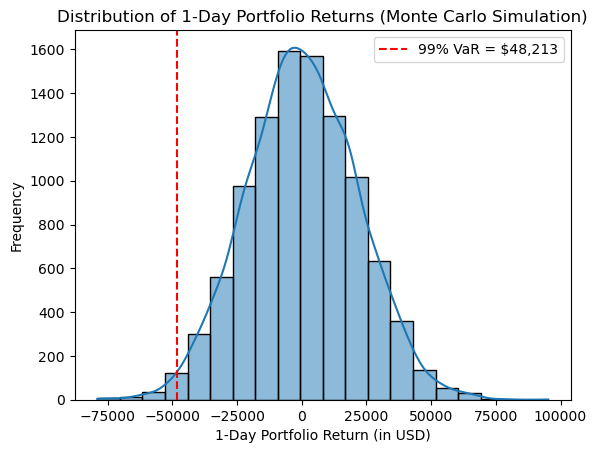

In [39]:
sns.histplot(portfolio_returns * portfolio_value, bins=20, kde=True)
plt.axvline(x=percentile * portfolio_value, color='red', linestyle='--', label=f'99% VaR = ${VaR_99:,.0f}')
plt.xlabel('1-Day Portfolio Return (in USD)')
plt.ylabel('Frequency')
plt.title('Distribution of 1-Day Portfolio Returns (Monte Carlo Simulation)')
plt.legend()
plt.show()